# Richardson-Lucy deconvolution: unfolding the spectrum

In the previous tutorial, we injected an analytic spectrum (a power law) and fitted it with the same functional form. That looks like cheating, but sometimes we do have good reasons to believe that the source spectrum will indeed have approximately a certain shape, so a "modeled search" is justified. We however don't want to be restricted only to modeled searches since our spectrum might have some interesting features that can go missing.    

As a way to illustrate this, let's inject a "weird" spectrum composed of two power-law components, one at low energies and one at high energy, joined at the peak energy of 1 MeV:

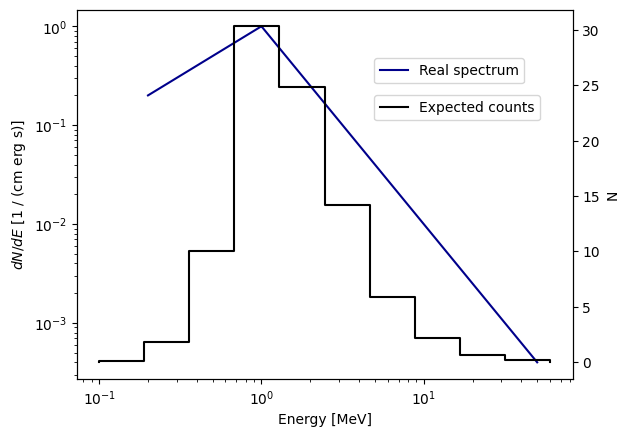

In [1]:
# Imports
from gammaraytoys.detectors import PowerLawSpectrum, PointSource, MultiComponentSpectrum
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from histpy import Histogram

# Observation duration
duration = 1*u.day

# Spectrum. Two components that are matched at 1 MeV
# Note: I used .999999*u.MeV as the max_energy of the first component 
# because the PDF range is closed on the left and open on the right i.e. [min_energy, max_energy)
component1 = PowerLawSpectrum(index = 1,  min_energy = 200*u.keV, max_energy = 0.999999*u.MeV)
component2 = PowerLawSpectrum(index = -2, min_energy = 1*u.MeV,   max_energy = 50*u.MeV)

smulti = MultiComponentSpectrum(component1,component2, 
                                weights = [1,component1.pdf(.999999*u.MeV)/component2.pdf(1*u.MeV)])

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = smulti,
                     flux_pivot = 1/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

# Convolve with the response
response = SpectralResponse.open("instrument_response/response_energy_onaxis_traddet.h5")

expected_signal_counts = response.expected_counts(source, duration)

# ==== Plots ====
fig,axl = plt.subplots()

# Real spectrum on the left axis
source.plot_spectrum(axl, e2 = False, label = 'Real spectrum', color = 'darkblue');
axl.legend(loc = (.6,.8))

# Observed counts on the right
axr = axl.twinx()
expected_signal_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.6,.7));

In the previous tutorial, we saw how we can obtain the best estimate $\hat{\mathrm{\Theta}}$ for the parameters $\mathrm{\Theta}$ by maximizing the likelihood:

$$\log \mathcal{L}(\mathrm{\Theta}) = \sum_k \left[N_k \log (\lambda_k(\mathrm{\Theta})) - \lambda_k(\mathrm{\Theta})\right ]  ~~~~~~~~~ \mathcal{L}(\hat{\mathrm{\Theta}}) = \max \mathcal{L}(\mathrm{\Theta})$$

The expected number of counts of each bin --$\left< N(\Delta E_{m_k}) \right>(\mathrm{\Theta}) = \lambda_k(\mathrm{\Theta})$-- was estimated by discretizing a spectrum that was a function of this parameters --$M_j = \int_{\Delta E_{i_j}} F(E;\mathrm{\Theta}) dE$-- and then "convolving" it with the response matrix. That is, the following dot product:


<div>
<img src="../figures/respose_dot_model.png" width="500"/>
</div>

Note: to simplify the notation, the response matrix here was already multiplied by the observation duration $\Delta t$.

This process depends on correctly modeling the source spectrum by a $F(E;\mathrm{\Theta})$ function. We can instead do what is called an "unmodelled" fit by making _each_ element of the discretized a free parameter! That is, $\mathrm{\Theta} = M_j$, as many free parameters as the number of elements in the discretized spectrum.

If you run the likelihood grid in the previous tutorial, you are probably imagining how slow fitting all of these parameters would be! Fortunately [William Richardson and Leon B. Lucy](https://en.wikipedia.org/wiki/Richardson–Lucy_deconvolution) realized that you can asymptotically approximate the $M_j = \mathrm{\Theta}$ values that maximize the likelihood using an iterative method.

The prescription is as follows:
1. Start with an arbitrary set of $M_j$ values
2. Compute the corresponding likelihood
3. Calculate the new $(n+1)$-th model with the following equation

$${\color{red} M_j}^{n+1} = \frac{{\color{red} M_j}^n}{\sum_k {\color {Orange} R_{kj}}} \sum_k {\color {Orange}  R_{jk}}  \frac{\color{Blue} N_k}{{\color{MidnightBlue}\lambda_k}^n} ~~~~~~~~ {\color{MidnightBlue} \lambda_k} = \sum_j {\color{Orange} R_{kj}} {\color{Red} M_j}$$

4. Repeat step 2 and 3 until the likelihood converges.

Each step involves:
1. ${\color{MidnightBlue} \lambda_k} = \sum_j {\color{Orange} R_{kj}} {\color{Red} M_j}$: Computing the expected number of counts giving our current best model
2. $\sum_k {\color {Orange}  R_{jk}}  \frac{\color{Blue} N_k}{{\color{MidnightBlue}\lambda_k}^n}$ Convolve the ratio of the observed and expected counts with the _transpose_ of the response.
3. Weight the result by the exposure $\Delta t A_{eff}(E_{i_j}) = \sum_k {\color {Orange} R_{kj}}$

Here's the implementation:

/Users/israel/work/software/histpy/histpy/histogram.py:1489: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


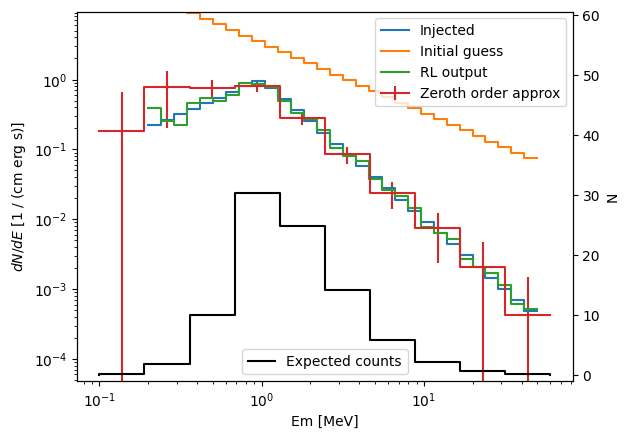

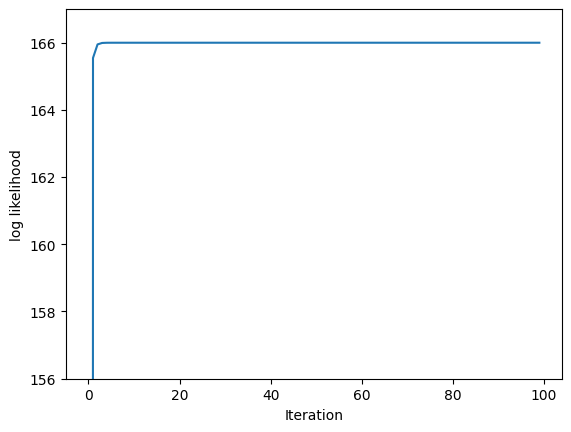

In [2]:
# Imports
from gammaraytoys.analysis import poisson_binned_log_likelihood
from copy import deepcopy

# Get a copy of the data.
# In order to get a sense of what to expect "on average" we'll
# ignore fluctuations for now and will set the data --the arrays 
# of counts on each bin N_k-- exactly to <N_k>
# In the exercise below you'll uncomment the Poisson fluctuations
# and see what happens.
data = deepcopy(expected_signal_counts)

# Uncomment the following line for the exercise
# data[:] = np.random.poisson(data.contents) 

# For reference, let's compute the O-th order approximation, the same
# as last time
approx_flux = Histogram(data.axis, data.contents, sumw2 = data.contents)
approx_flux /= duration # Per time
approx_flux /= response.effective_area().interp(data.axis.centers) # Per area

# ======= RL implementation ==============

# Initialize the model with an initial guess
# The exact values pretty much do not matter
# I just chose something that that falls within the
# range of the plot below
model_0 = Histogram(response.axes['Ei'], unit = 1/u.cm/u.s)
model_0[:] = 1e-6/u.cm/u.s # Doesn't matter much
                    
# Get the bare arrays and matrices used in the RL algorithm
model = deepcopy(model_0)
R_ij = response.contents.transpose() * duration
R_j = response.effective_area().contents * duration # This is the total exposure
M_j = model.contents
N_i = data.contents

# Array to keep track of the likelihood of each iteration
log_like = []

# RL iterative loop
niter = 100
for t in range(niter):

    # Compute the expected number of counts giving our current best model
    expectation = np.dot(R_ij, M_j)

    # Compute the corresponding likelihood
    log_like.append(poisson_binned_log_likelihood(data, expectation))

    # Convolve the ratio of the observed and expected counts with the transpose of the response.
    # Note: the nansum skips cases where both data and expectation are 0
    coeff = np.nansum((N_i/expectation)[:,None] * R_ij, axis = 0)
          
    # Weight the result by the exposure
    # This is equivalent to 
    # norm_coeff = coeff/R_j
    # but, similar to the nansum above, we want to handle 
    # cases where R_j = 0
    norm_coeff = np.zeros_like(coeff)
    np.divide(coeff, R_j, out = norm_coeff,
              where = (coeff!=0) | (R_j != 0))
    
    # Update the model
    M_j *= norm_coeff

# Put the new model array back into the Histogram format
model[:] = M_j


# ======= Spectrum plot ==============
fig,ax = plt.subplots()

# Real spectrum (discretized)
spec_binned = source.discretize_spectrum(response.axes['Ei'])
spect_tot_binned = spec_binned

# Convert the integrated spectrum on each bin to
# to flux energy density by dividing by the bin width
# Also make sure all have the same units
y_units = u.Unit(1/u.erg/u.cm/u.s)
spect_tot_binned_density = (spect_tot_binned/spect_tot_binned.axis.widths).to(y_units)
model_0_density = (model_0/model_0.axis.widths).to(y_units)
model_density = (model/model.axis.widths).to(y_units)
approx_flux_density = (approx_flux/approx_flux.axis.widths).to(y_units)

# Plot
spect_tot_binned_density.plot(ax, label = "Injected")
model_0_density.plot(ax, label = "Initial guess")
model_density.plot(ax, label = "RL output")
approx_flux_density.plot(ax, label = "Zeroth order approx", errorbars = True)

# Beautify it
ax.set_yscale('log')
ax.set_ylabel(f'$dN/dE$ [{y_units}]')
ax.legend(loc = 'upper right')
ax.set_ylim(.1*np.min(spect_tot_binned_density.contents.value), 10*np.max(spect_tot_binned_density.contents.value))

# Observed counts on the right
axr = ax.twinx()
expected_signal_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.set_ylim(-1, 2*np.max(expected_signal_counts))
axr.legend(loc = 'lower center');

# Likelihood evolution, on the right
fig,ax = plt.subplots()
ax.plot(log_like)
ax.set_ylim(np.max(log_like) - 10, np.max(log_like)+1)
ax.set_ylabel('log likelihood')
ax.set_xlabel('Iteration');

Since this is a simple case with only a small number of bins, RL converges pretty quickly. You can see that the likelihood becomes flat after just a few iterations, and the output of the algorithm is pretty close to the real injected spectrum. 

<div class="alert alert-block alert-info">
<b>Exercise: Poisson fluctuations and RL artifacts</b>
    
Uncomment the line with `np.random.poisson` above and run the RL reconvolution again many many times. Which range(s) in energy does the RL algorithm usually get right and which does not? Why is it so different from the case with no fluctuation?
    
The RL maximizes the likelihood at all costs. This means that it picks up statistical fluctuations and assigns them a flux that is inversely proportional to exposure --since flux = N/exposure. This means that the flux points provided by RL will have wild variations in regions with low exposure, in this case, caused by the low effective area near the edges of the energy range of the detector. These are usually called "artifacts". Since RL doesn't not provide you with the errors associated with each data points$^*$, you must be wary of over-interpreting the results. 
    
Once you run RL, resist the temptation of fitting the data points to a model! Instead, run your model through a forward folding likelihood analysis as we saw before.
    
$^*$ At least this simple "plain" RL implementation can't provide you with errors. There are some tricks that people do to estimate them, but in any case, they are very hard to compute correctly since you need to account for the correlations of all parameters, and we have many many of them in an "unmodeled" analysis!
</div>

In COSI, we usually use Richardon-Lucy to perform an imaging deconvolution, not just a "spectral" deconvolution. For imaging, each RL iteration becomes much slower, because the number of free parameters equals the number of energy bins times the pixel in the sky. That is, the $M_j$ model also includes the discretized spatial sky model. We'll get to that, but for now, it suffices to say that the code above remains unchanged when you do imaging, since you can always abstract the problem as a linear set of equations $R_{kj}M_j = N_k$--, where you have $R_{kj}$ (from simulation) and $N_k$ (your data) and you try to solve for $M_j$.